#0. Check device

In [1]:
# import
import torch
import datetime
import pandas as pd
import numpy as np

import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
# nltk.download("words") 
# nltk.download("punkt")
# nltk.download("wordnet")
# nltk.download("stopwords")
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
stopwords = set(stopwords.words("english"))

import warnings
warnings.filterwarnings("ignore")
import time

import torch
import torch.nn as nn
from transformers import BertModel


import os
from tqdm import tqdm, trange
import random
import time
import pickle
from sklearn.metrics import f1_score   

import re
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer
import pandas as pd
import datetime
import json
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd
import math
import time
import pprint
pp = pprint.PrettyPrinter()
import numpy as np
from sklearn.decomposition import PCA


import torch
 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, get_scheduler
from transformers import XLNetConfig,AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
from datasets import Dataset, load_dataset, load_metric
from sklearn.metrics import f1_score
from keras.preprocessing.sequence import pad_sequences


In [2]:

print(torch.cuda.is_available())
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device :",device)
torch.cuda.memory_summary(device=None, abbreviated=False)

True
Device : cuda:0


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [3]:
# params
max_model_length = 300
batch_size = 4
epoch_num = 12

1. load data 

In [4]:
# extrace time format

def extract_time(json, flag):
    '''
    for ranking time
    '''
    if flag == "v1":
        format = "%a %b %d %H:%M:%S +0000 %Y"
    else:
        format = "%Y-%m-%dT%H:%M:%S.%fZ"
    try:
        # convert created_at time format to datetime format
        return datetime.datetime.strptime(json['created_at'], format)
    except KeyError:
        return 0

In [5]:
# path to datasets
ids_dict = {
    'train':"project-data/train.data.txt"
    , 'dev':"project-data/dev.data.txt"
    , 'test':"project-data/test.data.txt"
}
labels_dict = {
    'train':"project-data/train.label.txt"
    , 'dev':"project-data/dev.label.txt"
}
tweet_json_dict = {
    'train':"project-data/crawl_data/train_data/"
    , 'dev':"project-data/crawl_data/dev_data/"
    , 'test': "project-data/tweet-objects/"
} 
time_format_dict = {
    'train':"v2"
    , 'dev':"v2"
    , 'test':"v1"
}

In [6]:
# load data from file function to pd.dataframe


def load2df(data_type):
  """
  Remove Invalid IDs, convert them into json and sort them 
  according to datetime
  return: dataframe, data_list
  """
  data_list = []
  label_list = []


  # open id file
  ids = open(ids_dict[data_type],"r")
  if data_type!='test':
    label = open(labels_dict[data_type],"r")

  # open corresponding tweet json files
  tweet_json_path = tweet_json_dict[data_type]
  if data_type == 'test':
    # go through every line in txt
    for ids_line in ids.readlines():
      ids_list = ids_line.strip().split(",")
      json_list = []  # store the content
      # deal with the source tweets that were not crawled
      for ids in ids_list:
        temp_file_path = tweet_json_path+ids+".json"
        temp_json = json.load(open(temp_file_path,"r"))
        json_list.append(temp_json)
      json_list.sort(key=lambda x: extract_time(x, time_format_dict[data_type]))
      #print(json_list)
      data_list.append(json_list)
    raw_text_list = []
    for i in range(len(data_list)):
      tweets = data_list[i]
      texts = []
      for tweet in tweets:
        text = tweet["text"]
        texts.append(text)
      raw_text_list.append(' '.join(texts))
    df = pd.DataFrame(list(raw_text_list), columns=['text'])
  else:
    # go through every line in txt
    for ids_line, label in zip(ids.readlines(), label.readlines()):
      ids_list = ids_line.strip().split(",")
      json_list = []  # store the content
      # deal with the source tweets that were not crawled
      if os.path.exists(tweet_json_path+ids_list[0]+".json"):
        # if id have tweet content
        for ids in ids_list:
          # check if the rest tweets were crawled
          temp_file_path = tweet_json_path+ids+".json"
          if os.path.exists(temp_file_path):
            temp_json = json.load(open(temp_file_path,"r"))
          json_list.append(temp_json)

        json_list.sort(key=lambda x: extract_time(x, time_format_dict[data_type]))
        #print(json_list)
        data_list.append(json_list)
        label_list.append(1 if label.strip()=="rumour" else 0)
    raw_text_list = []
    for i in range(len(data_list)):
      tweets = data_list[i]
      label = label_list[i]
      texts = []
      for tweet in tweets:
        text = tweet["text"]
        texts.append(text)
      raw_text_list.append(' '.join(texts))
    df = pd.DataFrame(list(zip(raw_text_list,label_list)), columns=['text','label'])
  return df, data_list


In [7]:
# load train
train_df, train_list = load2df('train')
train_df

,text,label
0,4. Can eating garlic help prevent infection wi...,0
1,French police chief killed himself after #Char...,1
2,Coronavirus disease (COVID-19) advice for the ...,0
3,Ottawa police confirm that there were multiple...,0
4,if the primary focus of a government isn't to ...,0
...,...,...
1272,What is a coronavirus?\nCoronaviruses are a la...,0
1273,The facts about coronavirus disease (COVID-19)...,0
1274,Can regularly rinsing your nose with saline he...,0
1275,FACT: Cold weather and snow cannot kill the ne...,0


In [8]:
dev_df, dev_list = load2df('dev')
dev_df

,text,label
0,COVID-19 Fact:\nAre hand dryers effective in k...,0
1,@atruchecks when can we expect the result of m...,0
2,I've read a lot about Corona virus lately and ...,0
3,"every news outlet using headlines like,\n\n""ar...",0
4,Researcher @naskrecki on his encounter with a ...,0
...,...,...
530,WHAT ARE THE TREATMENT OPTIONS FOR COVID-19 (I...,0
531,"After speculation that he’s been arrested, Ban...",1
532,*Your questions answered*❓\n\n*Reply with the ...,0
533,"►#Anonymous Operation #KKK ►Ku Klux Klan, We n...",1


In [9]:
test_df, test_list = load2df('test')
test_df

,text
0,How Does COVID-19 Spread? https://t.co/TXHDeUp...
1,"@brain_warrior If you don’t believe me, all yo..."
2,Q. How are COVID-19 and influenza viruses simi...
3,Una de les Q&amp;A on coronaviruses de la pàgi...
4,@MalaikaJabali @BenjaminPDixon We can’t forget...
...,...
553,Ex-Marlboro man dies from smoking-related dise...
554,Holy shit. Doritos flavored Mountain Dew.\n\nA...
555,Banksy account joins cartoonists support for #...
556,@DrTedros @WHOWPRO @WHOSEARO @WHO_Europe @paho...


EDA AND Preprocess

In [10]:
train_df.head(10)

,text,label
0,4. Can eating garlic help prevent infection wi...,0
1,French police chief killed himself after #Char...,1
2,Coronavirus disease (COVID-19) advice for the ...,0
3,Ottawa police confirm that there were multiple...,0
4,if the primary focus of a government isn't to ...,0
5,10. Are hand dryers effective in killing the n...,0
6,"Does the new coronavirus affect older people, ...",0
7,@WHOPhilippines @WHO_Mongolia @takeshi_kasai @...,0
8,A memorial for #MH17 victims forms near the Ne...,1
9,Prime Minister Tony Abbott's statement on the ...,0


0    1024
1     253
Name: label, dtype: int64


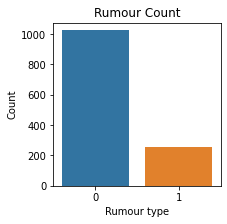

In [11]:

print(train_df['label'].value_counts()[:10])
plt.figure(figsize = (3, 3))
ax = plt.axes()
ax = sns.countplot(x = 'label', data = train_df)
plt.title('Rumour Count')
plt.xlabel('Rumour type')
plt.ylabel('Count')
plt.show()

0    420
1    115
Name: label, dtype: int64


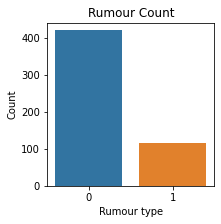

In [12]:

print(train_df['label'].value_counts()[:10])
plt.figure(figsize = (3, 3))
ax = plt.axes()
ax = sns.countplot(x = 'label', data = train_df)
plt.title('Rumour Count')
plt.xlabel('Rumour type')
plt.ylabel('Count')
plt.show()

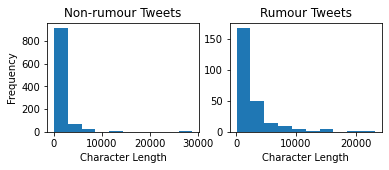

In [13]:
non_rumour_tweet_len = (train_df[train_df['label'] == 0])['text'].str.len()
rumour_tweet_len = (train_df[train_df['label'] == 1])['text'].str.len()
# print(non_rumour_tweet_len)
# print(rumour_tweet_len)

fig, axes = plt.subplots(1, 2, figsize = (6, 2))
axes[0].hist(non_rumour_tweet_len)
axes[0].set_title('Non-rumour Tweets')
axes[0].set_xlabel('Character Length')
axes[0].set_ylabel('Frequency')
axes[1].hist(rumour_tweet_len)
axes[1].set_title('Rumour Tweets')
axes[1].set_xlabel('Character Length')

plt.show()

In [14]:


def text_length(text, type = None):
    if not type:
        return len(str(text))
    elif type == 'words':
        return len(str(text).split())
    elif type == 'urls':
        return len([url for url in str(text).lower().split() if 'http' in text or 'https' in text])
    elif type == 'hashtags':
        return len([hashtag for hashtag in str(text) if '#' in hashtag])
    elif type == 'tags':
        return len([tag for tag in str(text) if '@' in tag])
    elif type == 'stopwords':
        return len([text for text in str(text).lower().split() if text in stopwords])
    

In [15]:
(train_df[train_df['label'] == 0])['text'].apply(lambda text:text_length(text,type='urls'))

0       244
2        77
3        74
4         0
5       112
       ... 
1272      0
1273    198
1274     90
1275    106
1276    110
Name: text, Length: 1024, dtype: int64

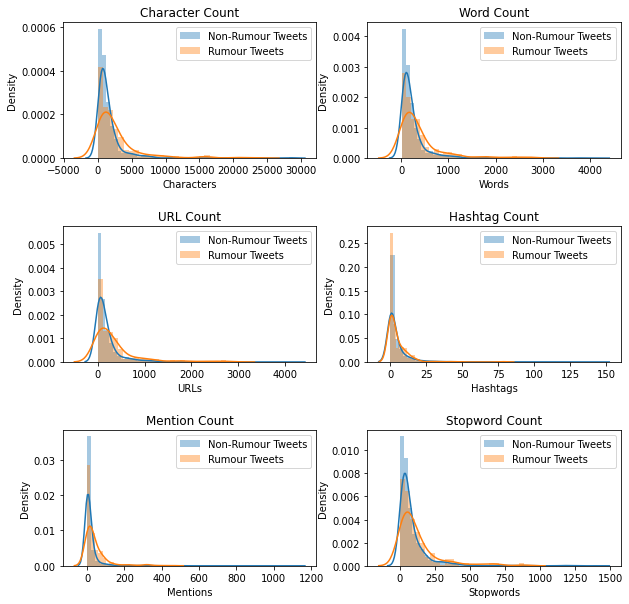

In [16]:

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 10))

sns.distplot(
    (train_df[train_df['label'] == 0])['text'].apply(lambda text:text_length(text))
    , ax = axes[0][0]
    , label = 'Non-Rumour Tweets')
sns.distplot(
    (train_df[train_df['label'] == 1])['text'].apply(lambda text:text_length(text))
    , ax = axes[0][0]
    , label = 'Rumour Tweets')
axes[0][0].set_title('Character Count')
axes[0][0].set_xlabel('Characters')
axes[0][0].set_ylabel('Density')
axes[0][0].legend().get_frame()

sns.distplot(
    (train_df[train_df['label'] == 0])['text'].apply(lambda text:text_length(text,type='words'))
    , ax = axes[0][1]
    , label = 'Non-Rumour Tweets')
sns.distplot(
    (train_df[train_df['label'] == 1])['text'].apply(lambda text:text_length(text,type='words'))
    , ax = axes[0][1]
    , label = 'Rumour Tweets')
axes[0][1].set_title('Word Count')
axes[0][1].set_xlabel('Words')
axes[0][1].set_ylabel('Density')
axes[0][1].legend().get_frame()

sns.distplot(
    (train_df[train_df['label'] == 0])['text'].apply(lambda text:text_length(text,type='urls'))
    , ax = axes[1][0]
    , label = 'Non-Rumour Tweets')
sns.distplot(
    (train_df[train_df['label'] == 1])['text'].apply(lambda text:text_length(text,type='urls'))
    , ax = axes[1][0]
    , label = 'Rumour Tweets')
axes[1][0].set_title('URL Count')
axes[1][0].set_xlabel('URLs')
axes[1][0].set_ylabel('Density')

axes[1][0].legend().get_frame()

sns.distplot(
    (train_df[train_df['label'] == 0])['text'].apply(lambda text:text_length(text,type='hashtags'))
    , ax = axes[1][1]
    , label = 'Non-Rumour Tweets')
sns.distplot(
    (train_df[train_df['label'] == 1])['text'].apply(lambda text:text_length(text,type='hashtags'))
    , ax = axes[1][1]
    , label = 'Rumour Tweets')
axes[1][1].set_title('Hashtag Count')
axes[1][1].set_xlabel('Hashtags')
axes[1][1].set_ylabel('Density')
axes[1][1].legend().get_frame()

sns.distplot(
    (train_df[train_df['label'] == 0])['text'].apply(lambda text:text_length(text,type='tags'))
    , ax = axes[2][0]
    , label = 'Non-Rumour Tweets')
sns.distplot(
    (train_df[train_df['label'] == 1])['text'].apply(lambda text:text_length(text,type='tags'))
    , ax = axes[2][0]
    , label = 'Rumour Tweets')
axes[2][0].set_title('Mention Count')
axes[2][0].set_xlabel('Mentions')
axes[2][0].set_ylabel('Density')
axes[2][0].legend().get_frame()

sns.distplot(
    (train_df[train_df['label'] == 0])['text'].apply(lambda text:text_length(text,type='stopwords'))
    , ax = axes[2][1]
    , label = 'Non-Rumour Tweets')
sns.distplot(
    (train_df[train_df['label'] == 1])['text'].apply(lambda text:text_length(text,type='stopwords'))
    , ax = axes[2][1]
    , label = 'Rumour Tweets')
axes[2][1].set_title('Stopword Count')
axes[2][1].set_xlabel('Stopwords')
axes[2][1].set_ylabel('Density')
axes[2][1].legend().get_frame()

plt.subplots_adjust(hspace = 0.5)
plt.show()

In [17]:

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 10))

sns.distplot(
    (dev_df[train_df['label'] == 0])['text'].apply(lambda text:text_length(text))
    , ax = axes[0][0]
    , label = 'Non-Rumour Tweets')
sns.distplot(
    (train_df[train_df['label'] == 1])['text'].apply(lambda text:text_length(text))
    , ax = axes[0][0]
    , label = 'Rumour Tweets')
axes[0][0].set_title('Character Count')
axes[0][0].set_xlabel('Characters')
axes[0][0].set_ylabel('Density')
axes[0][0].legend().get_frame()

sns.distplot(
    (train_df[train_df['label'] == 0])['text'].apply(lambda text:text_length(text,type='words'))
    , ax = axes[0][1]
    , label = 'Non-Rumour Tweets')
sns.distplot(
    (train_df[train_df['label'] == 1])['text'].apply(lambda text:text_length(text,type='words'))
    , ax = axes[0][1]
    , label = 'Rumour Tweets')
axes[0][1].set_title('Word Count')
axes[0][1].set_xlabel('Words')
axes[0][1].set_ylabel('Density')
axes[0][1].legend().get_frame()

sns.distplot(
    (train_df[train_df['label'] == 0])['text'].apply(lambda text:text_length(text,type='urls'))
    , ax = axes[1][0]
    , label = 'Non-Rumour Tweets')
sns.distplot(
    (train_df[train_df['label'] == 1])['text'].apply(lambda text:text_length(text,type='urls'))
    , ax = axes[1][0]
    , label = 'Rumour Tweets')
axes[1][0].set_title('URL Count')
axes[1][0].set_xlabel('URLs')
axes[1][0].set_ylabel('Density')

axes[1][0].legend().get_frame()

sns.distplot(
    (train_df[train_df['label'] == 0])['text'].apply(lambda text:text_length(text,type='hashtags'))
    , ax = axes[1][1]
    , label = 'Non-Rumour Tweets')
sns.distplot(
    (train_df[train_df['label'] == 1])['text'].apply(lambda text:text_length(text,type='hashtags'))
    , ax = axes[1][1]
    , label = 'Rumour Tweets')
axes[1][1].set_title('Hashtag Count')
axes[1][1].set_xlabel('Hashtags')
axes[1][1].set_ylabel('Density')
axes[1][1].legend().get_frame()

sns.distplot(
    (train_df[train_df['label'] == 0])['text'].apply(lambda text:text_length(text,type='tags'))
    , ax = axes[2][0]
    , label = 'Non-Rumour Tweets')
sns.distplot(
    (train_df[train_df['label'] == 1])['text'].apply(lambda text:text_length(text,type='tags'))
    , ax = axes[2][0]
    , label = 'Rumour Tweets')
axes[2][0].set_title('Mention Count')
axes[2][0].set_xlabel('Mentions')
axes[2][0].set_ylabel('Density')
axes[2][0].legend().get_frame()

sns.distplot(
    (train_df[train_df['label'] == 0])['text'].apply(lambda text:text_length(text,type='stopwords'))
    , ax = axes[2][1]
    , label = 'Non-Rumour Tweets')
sns.distplot(
    (train_df[train_df['label'] == 1])['text'].apply(lambda text:text_length(text,type='stopwords'))
    , ax = axes[2][1]
    , label = 'Rumour Tweets')
axes[2][1].set_title('Stopword Count')
axes[2][1].set_xlabel('Stopwords')
axes[2][1].set_ylabel('Density')
axes[2][1].legend().get_frame()

plt.subplots_adjust(hspace = 0.5)
plt.show()

{'not', 'on', 'than', 'because', 'didn', 'her', "hadn't", "shan't", "haven't", 'ourselves', "couldn't", "you'll", 'how', 'am', 'from', 'y', 'while', "should've", 'won', "doesn't", 'most', 've', 'off', 'you', "didn't", 'through', 'was', 'shouldn', 're', 'but', 'an', 'before', 'being', 'some', 'with', "hasn't", "needn't", "you'd", 'yourself', 'be', 'again', 'haven', 'me', 'has', 'few', 'own', 'hasn', "mustn't", 'at', 'why', 'then', 'each', 'nor', 'they', 'by', 'other', 'in', 'there', 'your', 'll', 'my', 'have', 'so', 'what', 'ours', 'itself', 'isn', 'been', 'aren', 'does', 'did', 'the', 'any', 'himself', "won't", 'such', 'both', 'just', 'do', 'too', 'into', 'down', 'over', 'needn', 'don', 'doesn', 'hers', 'if', 't', 'its', 'further', 'as', 'hadn', 'theirs', 'who', 'below', 'which', 'more', 'of', "mightn't", 'between', 'to', 'them', 'above', 'out', 'him', 'he', 'mustn', 'our', 'those', "she's", 'wasn', 'she', 'yourselves', 'all', 'couldn', 'themselves', 'shan', "weren't", "that'll", 'wher

In [18]:

def preprocess_text(text):
    new_text = ""
    temp_list = []
    text_list = text.split(" ")
    for word in text_list:
        temp = word.lower()
        # first to remove @user and urls
        if word.startswith('@') and len(word) > 1:
            temp_list.append('')
        elif word.startswith('http'):
            temp_list.append('')
        # remove word that doesn't contains alphabetic
        elif not re.search('[a-zA-Z]', word) or len(word)< 2 or (not word) or word in stopwords:
            continue
        else:
            # lemmatize
            temp = WordNetLemmatizer().lemmatize(temp, pos="v")
            temp_list.append(temp)
    new_text = ' '.join(temp_list)
    # remove emoji
    emoji_pattern = re.compile('['
                           u'\U0001F600-\U0001F64F'
                           u'\U0001F300-\U0001F5FF'
                           u'\U0001F680-\U0001F6FF'
                           u'\U0001F1E0-\U0001F1FF'
                           u'\U00002702-\U000027B0'
                           u'\U000024C2-\U0001F251'
                           ']+', flags=re.UNICODE)
    new_text = emoji_pattern.sub(r'', new_text)
    # remove html
    html = re.compile(r'<[^>]+>')
    new_text = html.sub('', new_text)
    return new_text

In [19]:
from collections import Counter
import string

import warnings
warnings.filterwarnings('ignore')
train_df['text_processed'] = train_df['text'].apply(lambda text: preprocess_text(text)) 
train_df['text_processed'] = train_df['text_processed'].str.translate(str.maketrans('', '', string.punctuation))
train_df

dev_df['text_processed'] = dev_df['text'].apply(lambda text: preprocess_text(text)) 
dev_df['text_processed'] = dev_df['text_processed'].str.translate(str.maketrans('', '', string.punctuation))

test_df['text_processed'] = test_df['text'].apply(lambda text: preprocess_text(text)) 
test_df['text_processed'] = test_df['text_processed'].str.translate(str.maketrans('', '', string.punctuation))


In [41]:
counter = Counter()
for text in train_df['text_processed'].values:
    for word in text.split():
        if word not in stopwords and word not in ['someone','httplink']:
            counter[word] += 1
counter.most_common(10)

[('covid19', 2071),
 ('coronavirus', 1955),
 ('people', 1710),
 ('new', 1682),
 ('get', 954),
 ('virus', 900),
 ('like', 857),
 ('say', 760),
 ('go', 637),
 ('know', 616)]

In [42]:
counter = Counter()
for text in dev_df['text_processed'].values:
    for word in text.split():
        if word not in stopwords and word not in ['someone','httplink']:
            counter[word] += 1
counter.most_common(10)

[('covid19', 942),
 ('coronavirus', 735),
 ('people', 656),
 ('new', 599),
 ('get', 393),
 ('say', 386),
 ('virus', 375),
 ('hand', 360),
 ('make', 352),
 ('like', 338)]

In [43]:
counter = Counter()
for text in test_df['text_processed'].values:
    for word in text.split():
        if word not in stopwords and word not in ['someone','httplink']:
            counter[word] += 1
counter.most_common(10)

[('coronavirus', 526),
 ('covid19', 480),
 ('new', 464),
 ('people', 440),
 ('like', 298),
 ('say', 289),
 ('get', 275),
 ('spider', 251),
 ('rt', 229),
 ('go', 207)]

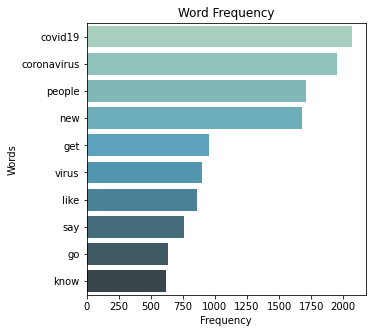

In [21]:
data = dict(sorted(counter.items(), key = lambda x: x[1] ,reverse = True)[:10])
words = list(data.keys())
frequency = list(data.values())

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
ax = sns.barplot(x = frequency, y = words,palette="GnBu_d")
plt.title('Word Frequency')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

In [22]:
from collections import defaultdict
def get_ngrams(text, n_gram = 1):
    tokens = []
    for token in text.lower().split(' '):
        if len(token)>=2 and token not in stopwords:
            tokens.append(token)
    return [' '.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n_gram)])]

def get_ngrams_dict(df, n_gram = 1, top = 10):
    ngram_dict = defaultdict(int)
    for tweet in df['text_processed']:
        for word in get_ngrams(tweet, n_gram = n_gram):
            ngram_dict[word] += 1

    ngram_dict_data = dict(sorted(ngram_dict.items(), key = lambda x: x[1], reverse = True)[:top])
    ngram_dict_words = list(ngram_dict_data.keys())
    ngram_dict_frequency = list(ngram_dict_data.values())
    return ngram_dict_words, ngram_dict_frequency


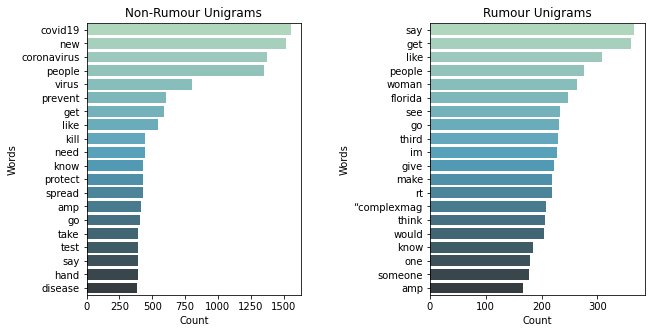

In [23]:
non_rumour_ngram_words, non_rumour_ngram_frequency = get_ngrams_dict(train_df[train_df['label'] == 0], n_gram = 1, top = 20)
rumour_ngram_words, rumour_ngram_frequency = get_ngrams_dict(train_df[train_df['label'] == 1], n_gram = 1, top = 20)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
sns.barplot(x = non_rumour_ngram_frequency, y = non_rumour_ngram_words, ax = axes[0],palette="GnBu_d")
axes[0].set_title('Non-Rumour Unigrams')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Words')
axes[0].xaxis.set_tick_params()
axes[0].yaxis.set_tick_params()
sns.barplot(x = rumour_ngram_frequency, y = rumour_ngram_words, ax = axes[1],palette="GnBu_d")
axes[1].set_title('Rumour Unigrams')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Words')
axes[1].xaxis.set_tick_params()
axes[1].yaxis.set_tick_params()
plt.subplots_adjust(wspace = 0.6)

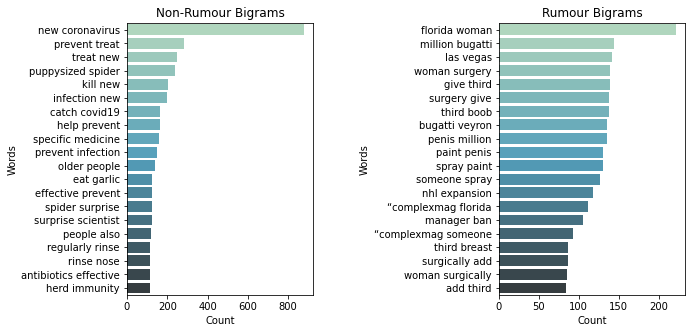

In [24]:
non_rumour_ngram_words, non_rumour_ngram_frequency = get_ngrams_dict(train_df[train_df['label'] == 0], n_gram = 2, top = 20)
rumour_ngram_words, rumour_ngram_frequency = get_ngrams_dict(train_df[train_df['label'] == 1], n_gram = 2, top = 20)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
sns.barplot(x = non_rumour_ngram_frequency, y = non_rumour_ngram_words, ax = axes[0],palette="GnBu_d")
axes[0].set_title('Non-Rumour Bigrams')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Words')
axes[0].xaxis.set_tick_params()
axes[0].yaxis.set_tick_params()
sns.barplot(x = rumour_ngram_frequency, y = rumour_ngram_words, ax = axes[1],palette="GnBu_d")
axes[1].set_title('Rumour Bigrams')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Words')
axes[1].xaxis.set_tick_params()
axes[1].yaxis.set_tick_params()
plt.subplots_adjust(wspace = 1)

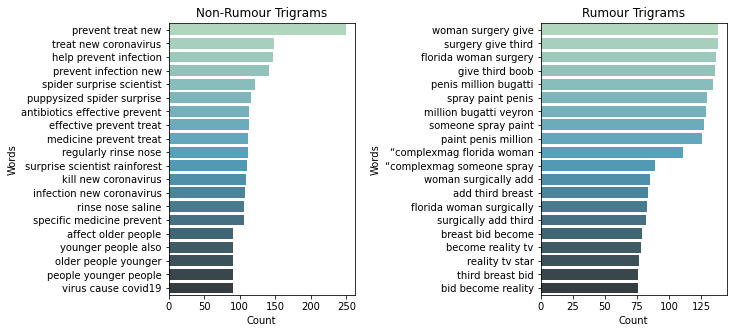

In [25]:
non_rumour_ngram_words, non_rumour_ngram_frequency = get_ngrams_dict(train_df[train_df['label'] == 0], n_gram = 3, top = 20)
rumour_ngram_words, rumour_ngram_frequency = get_ngrams_dict(train_df[train_df['label'] == 1], n_gram = 3, top = 20)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
sns.barplot(x = non_rumour_ngram_frequency, y = non_rumour_ngram_words, ax = axes[0],palette="GnBu_d")
axes[0].set_title('Non-Rumour Trigrams')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Words')
axes[0].xaxis.set_tick_params()
axes[0].yaxis.set_tick_params()
sns.barplot(x = rumour_ngram_frequency, y = rumour_ngram_words, ax = axes[1],palette="GnBu_d")
axes[1].set_title('Rumour Trigrams')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Words')
axes[1].xaxis.set_tick_params()
axes[1].yaxis.set_tick_params()
plt.subplots_adjust(wspace = 1)

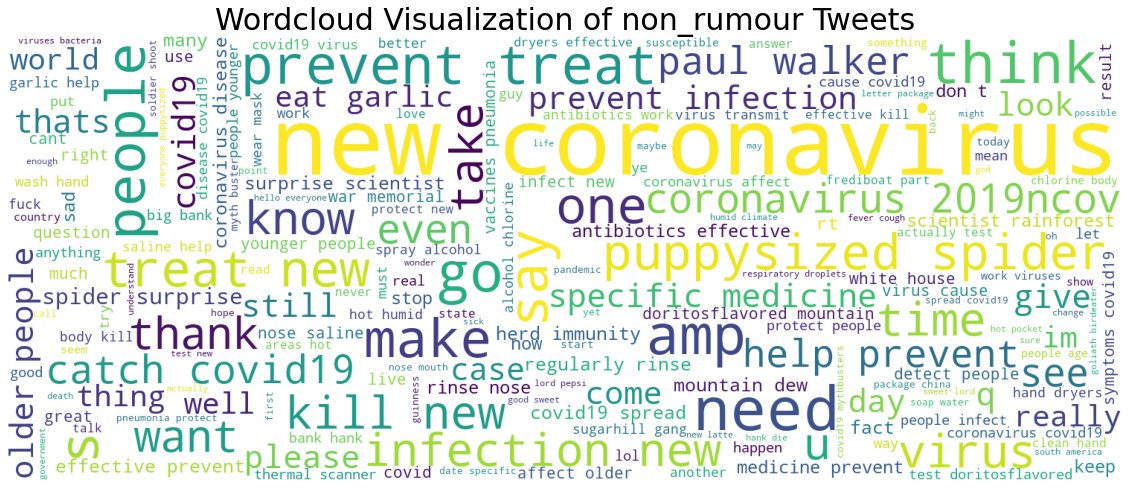

In [33]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1500, height = 600, background_color = 'white').generate(''.join(text for text in train_df[train_df['label'] == 0]['text_processed']))
plt.figure(figsize = (20, 10))
plt.title('Wordcloud Visualization of non_rumour Tweets', fontsize = 30)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

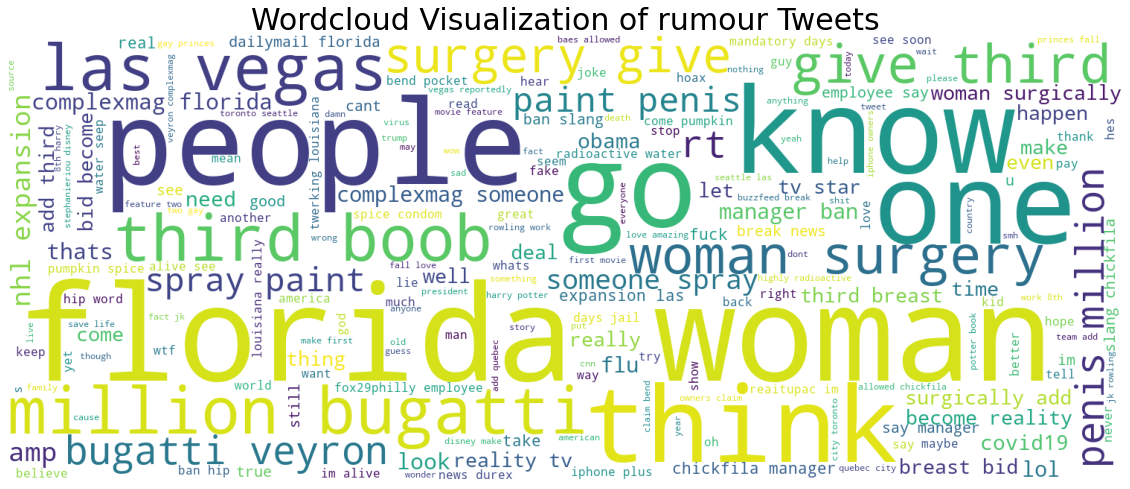

In [34]:
wordcloud = WordCloud(width = 1500, height = 600, background_color = 'white').generate(''.join(text for text in train_df[train_df['label'] == 1]['text_processed']))
plt.figure(figsize = (20, 10))
plt.title('Wordcloud Visualization of rumour Tweets', fontsize = 30)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

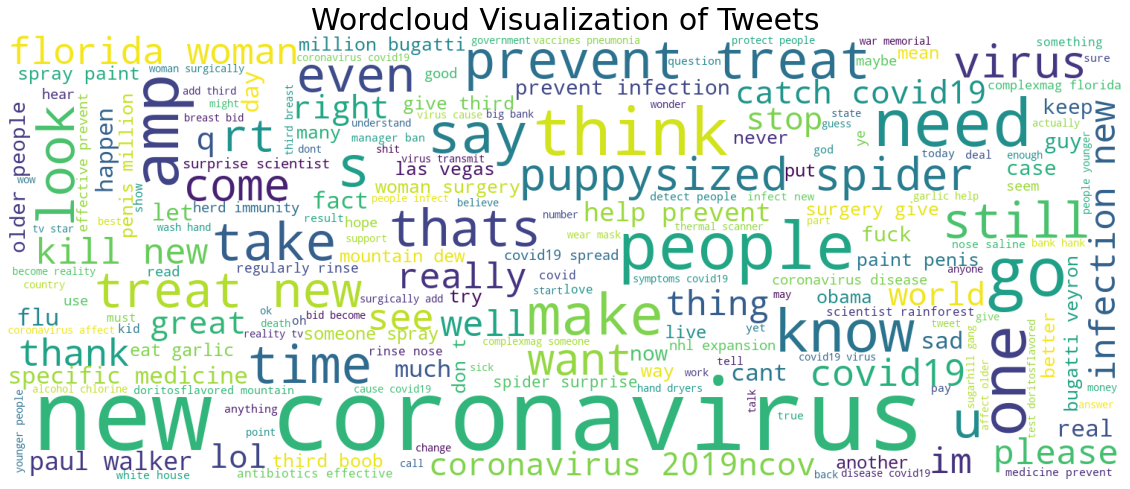

In [35]:
wordcloud = WordCloud(width = 1500, height = 600, background_color = 'white').generate(''.join(text for text in train_df['text_processed']))
plt.figure(figsize = (20, 10))
plt.title('Wordcloud Visualization of Tweets', fontsize = 30)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [29]:
#Load data to datasets


In [30]:

class base_dataset(Dataset):

    def __init__(self, dataframe, tokenizer, maxlen): #dataframe: df_dev or df_train
        self.df = dataframe
        self.tokenizer = tokenizer 
        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.df.loc[index, 'text_processed']
        label = self.df.loc[index, 'label']
        # eventID = self.df.loc[index, 'id']

        tokens = self.tokenizer.tokenize(text) #Tokenize the text
        tokens = ['[CLS]'] + tokens + ['[SEP]'] 
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))] #Padding sentences
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]'] #Prunning the list to be of specified max length

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
        encoding_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor

        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (encoding_tensor != 0).long()

        return encoding_tensor, attn_mask, label 

class test_dataset(Dataset):

    def __init__(self, dataframe, tokenizer, maxlen): #dataframe: df_dev or df_train

        #Store the contents of the file in a pandas dataframe
        self.df = dataframe

        #Initialize the BERT tokenizer
        self.tokenizer = tokenizer 

        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        #Selecting the text and label at the specified index in the data frame
        text = self.df.loc[index, 'text_processed']
        
        # label = self.df.loc[index, 'label']
        # eventID = self.df.loc[index, 'id']
        


        #Preprocessing the text to be suitable for BERT
        tokens = self.tokenizer.tokenize(text) #Tokenize the text
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))] #Padding sentences
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]'] #Prunning the list to be of specified max length

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
        encoding_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor

        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (encoding_tensor != 0).long()

        return encoding_tensor, attn_mask # , label 

In [32]:
# load data and do simple prerocessing
from torch.utils.data import DataLoader

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_set = base_dataset(dataframe = train_df, tokenizer=tokenizer, maxlen=300) 
dev_set = base_dataset(dataframe = dev_df, tokenizer=tokenizer, maxlen=300) 
test_set = test_dataset(dataframe = test_df, tokenizer=tokenizer, maxlen=300)

train_loader = DataLoader(train_set, batch_size=4, num_workers=0)
dev_loader = DataLoader(dev_set, batch_size=4, num_workers=0)
test_loader = DataLoader(test_set, batch_size=4, num_workers=0)


In [ ]:

class SentimentClassifier(nn.Module):

    def __init__(self):
        super(SentimentClassifier, self).__init__()
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        self.cls_layer = nn.Linear(768, 1) #initialize the layer

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        outputs = self.bert_layer(seq, attention_mask = attn_masks)
        cont_reps = outputs.last_hidden_state

        #Obtaining the representation of [CLS] head (the first token)
        cls_rep = cont_reps[:, 0] #for all the context, just take the first cls token

        #Feeding cls_rep to the classifier layer
        logits = self.cls_layer(cls_rep)

        return logits

In [ ]:
gpu = 0 #gpu ID

print("Creating the sentiment classifier, initialised with pretrained BERT-BASE parameters...")
net = SentimentClassifier() #initailize the net
net.cuda(gpu) #Enable gpu support for the model #tell the model to move to GPU
print("Done creating the sentiment classifier.")

Creating the sentiment classifier, initialised with pretrained BERT-BASE parameters...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Done creating the sentiment classifier.


In [ ]:
criterion = nn.BCEWithLogitsLoss()  #BCE: binary cross entropy
opti = optim.Adam(net.parameters(), lr = 2e-5) #optimizer

In [ ]:

def get_accuracy_from_logits(logits, labels):

  probs = torch.sigmoid(logits.unsqueeze(-1))
  soft_probs = (probs > 0.5).long()
  mask = [1] * labels.size()[0]
  mask = torch.FloatTensor(mask).cuda(0)
  precision = (((soft_probs.squeeze() == labels)&(labels==mask)).float().mean()) / ((soft_probs.squeeze() == 1).float().mean())
  recall = (((soft_probs.squeeze() == labels)&(labels==mask)).float().mean()) / (labels==mask).float().mean()
  f1 = (2*precision*recall) / (precision+recall)
  if torch.isnan(f1):
      f1 = 0
  return f1

def evaluate(net, criterion, dataloader, device):
  net.eval()

  mean_f1, mean_loss = 0, 0
  count = 0

  with torch.no_grad():
    for seq, attn_masks, labels in dataloader:
      seq, attn_masks, labels = seq.cuda(device), attn_masks.cuda(device), labels.cuda(device)
      logits = net(seq, attn_masks)
      mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
      mean_f1 += get_accuracy_from_logits(logits, labels)
      count += 1

  return mean_f1 / count, mean_loss / count

In [ ]:


def train(net, criterion, opti, train_loader, dev_loader, max_eps, gpu):
    net.train()
    train_loss_curve = []
    train_f1_curve = []
    dev_loss_curve = []
    dev_f1_curve = []
    for ep in range(max_eps):
        print("start epoch {}...".format(ep))
        for it, (seq, attn_masks, labels) in enumerate(tqdm(train_loader)):
            #Clear gradients
            opti.zero_grad()
            seq, attn_masks, labels = seq.cuda(gpu), attn_masks.cuda(gpu), labels.cuda(gpu)

            #Obtaining the logits from the model
            logits = net(seq, attn_masks)

            #Computing loss
            loss = criterion(logits.squeeze(-1), labels.float())

            #Backpropagating the gradients
            loss.backward()

            #Optimization step
            opti.step() #update the weight with the gradient

        train_f1, train_loss = evaluate(net, criterion, train_loader, device)
        train_loss_curve.append(train_loss)
        train_f1_curve.append(train_f1)

        dev_f1, dev_loss = evaluate(net, criterion, dev_loader, device)
        dev_loss_curve.append(dev_loss)
        dev_f1_curve.append(dev_f1)

        print("Epoch {} complete! Train F1: {}; Train Loss: {} Dev F1: {}; Dev Loss: {}".format(ep, train_f1, train_loss,dev_f1, dev_loss))
        torch.save(net.state_dict(), 'Result/bertcls_{}.dat'.format(ep))
    return train_loss_curve, train_f1_curve, dev_loss_curve, dev_f1_curve

In [ ]:
def predict(net, dataloader):
  """
  Use fine tuned bert to predict (forward)
  """
  net.eval()
  logits = []

  # c = 0
  # go through each batch
  for seq, attn_masks in dataloader:
    # print(c)
    # c += 1
    # compute logits
    with torch.no_grad():
      logit = net(seq.to(device), attn_masks.to(device))
    logits.append(logit)
  # concatenate batch
  logits = torch.cat(logits,dim=0)
  # print(logits)
  # calculate probs
  # print(logits)

  probs = torch.sigmoid(logits.squeeze(-1))
  # probs = F.softmax(logits, dim=1).cpu().numpy()
  # probs = logits.argmax(dim=1)
  return probs

In [ ]:
num_epoch = 10
torch.cuda.empty_cache() #empty the cache before training to prevent memory error
#fine-tune the model
train_loss_curve, train_f1_curve, dev_loss_curve, dev_f1_curve = train(net, criterion, opti, train_loader, dev_loader, num_epoch, gpu)
torch.save(net.state_dict(), 'Result/bertcls_{}.dat'.format(num_epoch-1))

start epoch 0...


100%|██████████| 320/320 [01:28<00:00,  3.63it/s]


Epoch 0 complete! Train F1: 0.5885416865348816; Train Loss: 0.006972362601663918 Dev F1: 0.531592071056366; Dev Loss: 0.21433952287814245
start epoch 1...


100%|██████████| 320/320 [01:30<00:00,  3.53it/s]


Epoch 1 complete! Train F1: 0.5729166865348816; Train Loss: 0.02541640001363703 Dev F1: 0.5601990818977356; Dev Loss: 0.23445040173481094
start epoch 2...


100%|██████████| 320/320 [01:37<00:00,  3.29it/s]


Epoch 2 complete! Train F1: 0.590624988079071; Train Loss: 0.001495220896867977 Dev F1: 0.5368160009384155; Dev Loss: 0.2167813791554602
start epoch 3...


100%|██████████| 320/320 [01:40<00:00,  3.18it/s]


Epoch 3 complete! Train F1: 0.5895833373069763; Train Loss: 0.010842564965423662 Dev F1: 0.5781095027923584; Dev Loss: 0.255601477159844
start epoch 4...


100%|██████████| 320/320 [01:42<00:00,  3.13it/s]


Epoch 4 complete! Train F1: 0.5843750238418579; Train Loss: 0.011879390151807456 Dev F1: 0.5019900798797607; Dev Loss: 0.20578411687339254
start epoch 5...


100%|██████████| 320/320 [01:41<00:00,  3.16it/s]


Epoch 5 complete! Train F1: 0.590624988079071; Train Loss: 0.0005972890999601077 Dev F1: 0.5099503397941589; Dev Loss: 0.2349811555170923
start epoch 6...


100%|██████████| 320/320 [01:34<00:00,  3.38it/s]


Epoch 6 complete! Train F1: 0.590624988079071; Train Loss: 0.000354135179259174 Dev F1: 0.5099503397941589; Dev Loss: 0.24298955498681554
start epoch 7...


100%|██████████| 320/320 [01:28<00:00,  3.60it/s]


Epoch 7 complete! Train F1: 0.590624988079071; Train Loss: 0.000266823023298457 Dev F1: 0.5124378204345703; Dev Loss: 0.25497401944503234
start epoch 8...


100%|██████████| 320/320 [01:28<00:00,  3.62it/s]


Epoch 8 complete! Train F1: 0.590624988079071; Train Loss: 0.00021168107473386045 Dev F1: 0.5124378204345703; Dev Loss: 0.26509656488497735
start epoch 9...


100%|██████████| 320/320 [01:28<00:00,  3.63it/s]


Epoch 9 complete! Train F1: 0.590624988079071; Train Loss: 0.0001732716836158943 Dev F1: 0.5124378204345703; Dev Loss: 0.27419990217246926


In [ ]:

probs = predict(net, test_loader)
print(probs)
threshold = 0.5
predicts = probs.cpu().detach().numpy()
predicts = np.where(predicts>threshold,1,0)
print(predict)


pd.DataFrame(predicts).to_csv("submission.csv")

tensor([1.5124e-04, 1.8768e-03, 8.3385e-05, 1.0718e-04, 7.3816e-04, 1.2758e-04,
        1.5880e-03, 9.3334e-01, 2.3611e-04, 8.0905e-01, 9.9348e-01, 9.9951e-01,
        3.2410e-04, 9.9904e-01, 4.0343e-04, 9.4803e-05, 1.4134e-04, 1.8248e-04,
        1.4183e-04, 8.5235e-05, 2.1200e-02, 1.2716e-04, 1.8009e-04, 9.9980e-01,
        7.7468e-03, 1.2803e-04, 1.0076e-04, 9.9951e-01, 8.4947e-05, 9.9973e-01,
        2.1103e-04, 9.9931e-01, 9.8633e-01, 1.2598e-04, 2.0881e-04, 8.7085e-05,
        8.5625e-05, 1.5179e-04, 1.1467e-04, 9.5152e-03, 2.6707e-03, 7.0584e-03,
        1.2790e-04, 1.2401e-04, 1.4215e-04, 1.0414e-04, 1.6695e-04, 2.2876e-03,
        9.8946e-05, 1.0627e-04, 1.2032e-04, 1.1713e-04, 9.9977e-01, 1.8169e-04,
        1.3129e-04, 1.9831e-03, 9.9980e-01, 8.4721e-05, 1.5809e-04, 1.0198e-04,
        8.3423e-05, 9.9603e-01, 1.0293e-04, 1.2374e-04, 1.0505e-04, 8.1821e-05,
        9.9217e-01, 2.6647e-04, 1.1722e-04, 1.4538e-04, 1.2084e-04, 8.0181e-05,
        1.7848e-04, 9.9943e-01, 8.0869e-